In [1]:
%load_ext autoreload
%autoreload

## This expands a notebook to full width
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("""<style>div.output_area{max-height:10000px;overflow:scroll;}</style>"""))
## Show Python Version
import sys
print("Python: {0}".format(sys.version))

## Show Current Time
import datetime as dt
start = dt.datetime.now()
print("Notebook Last Run Initiated: "+str(start))

Python: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Notebook Last Run Initiated: 2022-06-13 21:03:02.463322


In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold
from sklearn.metrics.pairwise import cosine_similarity

from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
%matplotlib inline

In [73]:
# Input vector, returns nearest word(s)
def Cosine_Similarity(word,weight,word_to_index,vocab_size,index_to_word):
    
    #Get the index of the word from the dictionary
    index = word_to_index[word]
    
    #Get the correspondin weights for the word
    word_vector_1 = weight[index]
    
    
    word_similarity = {}

    for i in range(vocab_size):
        
        j = i
        
        word_vector_2 = weight[j]
        
        theta_sum = np.dot(word_vector_1, word_vector_2)
        theta_den = np.linalg.norm(word_vector_1) * np.linalg.norm(word_vector_2)
        theta = theta_sum / theta_den
        
        word = index_to_word[j]
        word_similarity[word] = theta
    
    return word_similarity #words_sorted

In [4]:
# define documents
data = pd.read_csv('data\ZIP2LATLON_VER1.csv',dtype={
                   'postal_code': str,
                   'country_code': str,
                   'place': str,
                   'state': str,
                   'statecode': str,
                   'province_or_county': str,
                   'province_or_countycode': str,
                   'latitude': float,
                   'longitude': float})

data['postal_code'] = data['postal_code'].str.zfill(5)

In [5]:
#data = data.fillna(0)

In [6]:
target = data[['latitude','longitude']]
data = data[['postal_code','country_code','place','state','statecode','province_or_county','province_or_countycode']]

In [7]:
target = StandardScaler().fit_transform(target.values)

In [8]:
#data['province_or_county'].replace([0], 'NONE ', inplace=True)

In [9]:
docs = data.iloc[:,0:6].apply(lambda x: ' '.join(x), axis=1)

In [10]:
# integer encode the documents
vocab_size = 61837
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(docs)

In [11]:
encoded_docs = t.texts_to_sequences(docs)

In [12]:
# pad documents to a max length of 7 words
max_length = 6
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [13]:
def BuildModel(learning_rate):
        
    input_text  = tf.keras.layers.Input(shape=(max_length,),name='text')

    x = tf.keras.layers.Embedding(vocab_size, 20, input_length=max_length,name='embeddings')(input_text)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(40, activation='relu',name='act01')(x)
    output = tf.keras.layers.Dense(1, activation='linear',name='linear_output')(x)
    
    model = Model(input_text,output)
    
    model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate))
    return model

In [14]:
learning_rate = 1e-3
n_epochs = 250

model = BuildModel(learning_rate)
        
ckp_path = f'models/Model_05.hdf5'

cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.4, patience = 5, verbose = 0, min_delta = 0.001, mode = 'min')
        
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=0, patience=10, restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint(ckp_path, monitor='loss', mode='min', verbose=0, save_best_only=True, save_weights_only=True)
        
    #tb_cb = tf.keras.callbacks.TensorBoard(log_dir="logs")

# train the model
model.fit(padded_docs,target,epochs=n_epochs, batch_size=256,
          callbacks=[mc,cb_lr_schedule,es], shuffle=False,
          workers=-1, use_multiprocessing=True, verbose=2)
        


Epoch 1/250
161/161 - 1s - loss: 0.9944 - lr: 0.0010 - 1s/epoch - 8ms/step
Epoch 2/250
161/161 - 1s - loss: 0.7898 - lr: 0.0010 - 694ms/epoch - 4ms/step
Epoch 3/250
161/161 - 1s - loss: 0.6410 - lr: 0.0010 - 680ms/epoch - 4ms/step
Epoch 4/250
161/161 - 1s - loss: 0.6063 - lr: 0.0010 - 690ms/epoch - 4ms/step
Epoch 5/250
161/161 - 1s - loss: 0.5858 - lr: 0.0010 - 668ms/epoch - 4ms/step
Epoch 6/250
161/161 - 1s - loss: 0.5807 - lr: 0.0010 - 682ms/epoch - 4ms/step
Epoch 7/250
161/161 - 1s - loss: 0.5744 - lr: 0.0010 - 675ms/epoch - 4ms/step
Epoch 8/250
161/161 - 1s - loss: 0.5800 - lr: 0.0010 - 671ms/epoch - 4ms/step
Epoch 9/250
161/161 - 1s - loss: 0.5950 - lr: 0.0010 - 644ms/epoch - 4ms/step
Epoch 10/250
161/161 - 1s - loss: 0.5727 - lr: 0.0010 - 684ms/epoch - 4ms/step
Epoch 11/250
161/161 - 1s - loss: 0.5635 - lr: 0.0010 - 664ms/epoch - 4ms/step
Epoch 12/250
161/161 - 1s - loss: 0.5587 - lr: 0.0010 - 667ms/epoch - 4ms/step
Epoch 13/250
161/161 - 1s - loss: 0.5564 - lr: 0.0010 - 669ms/ep

Epoch 101/250
161/161 - 1s - loss: 0.5389 - lr: 1.0737e-09 - 660ms/epoch - 4ms/step
Epoch 102/250
161/161 - 1s - loss: 0.5389 - lr: 1.0737e-09 - 647ms/epoch - 4ms/step
Epoch 103/250
161/161 - 1s - loss: 0.5389 - lr: 4.2950e-10 - 657ms/epoch - 4ms/step


In [15]:
# evaluate the model
loss = model.evaluate(padded_docs, target, verbose=2)
print(loss)

1286/1286 - 2s - loss: 0.5389 - 2s/epoch - 1ms/step
0.5389259457588196


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 6)]               0         
                                                                 
 embeddings (Embedding)      (None, 6, 20)             1236740   
                                                                 
 flatten (Flatten)           (None, 120)               0         
                                                                 
 act01 (Dense)               (None, 40)                4840      
                                                                 
 linear_output (Dense)       (None, 1)                 41        
                                                                 
Total params: 1,241,621
Trainable params: 1,241,621
Non-trainable params: 0
_________________________________________________________________


In [17]:
embedding_layer = model.get_layer('embeddings')

In [18]:
embeddings = embedding_layer.get_weights()[0]

In [19]:
np.savetxt("embeddings_model3.csv", embeddings, delimiter=",")

In [20]:
embeddings[t.word_index['60126'],:]

array([ 0.04473591,  0.02182251,  0.02718688, -0.05789768,  0.0315198 ,
       -0.01363557, -0.04941428, -0.05951649,  0.04166807,  0.06693738,
       -0.08285856, -0.02041151, -0.01219045, -0.01249371,  0.01298883,
        0.04943318,  0.04484977, -0.01407567,  0.02586767, -0.01988386],
      dtype=float32)

In [21]:
cosine_similarity(np.reshape(embeddings[t.word_index['60126'],:],(1,20)),np.reshape(embeddings[t.word_index['55929'],:],(1,20)))[0][0]

-0.26024082

In [22]:
1. - cdist(np.reshape(embeddings[t.word_index['60126'],:],(1,20)), np.reshape(embeddings[t.word_index['60163'],:],(1,20)), 'cosine')[0][0]

0.33873274207116255

In [23]:
states = pd.DataFrame(pd.unique(data.statecode),columns=['states'])

In [24]:
states_list = []

for index, row in states.iterrows():
    state = row[0].lower()
    states_list.append(pd.concat([pd.Series(state), pd.DataFrame(np.reshape(embeddings[t.word_index[state],:],(1,20)))   ],axis=1))   

In [25]:
states = pd.concat(states_list)
states = states.reset_index(drop=True)

In [26]:
states.columns = range(states.columns.size)

In [27]:
x = StandardScaler().fit_transform(states.iloc[:,1:-1].values)

In [28]:
#pca = PCA(n_components=2)

In [29]:
#principalComponents = pca.fit_transform(x)

In [30]:
#TSNE : Compressing the weights to 2 dimensions to plot the data
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(x)

C:\Users\jpalma3\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\jpalma3\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [33]:
principalDf = pd.DataFrame(data = new_values
             , columns = ['principal component 1', 'principal component 2'])

In [34]:
#principalDf = pd.DataFrame(data = principalComponents
#             , columns = ['principal component 1', 'principal component 2'])

In [35]:
finalDf = pd.concat([principalDf, states.iloc[:,0]], axis = 1)
finalDf.columns = ['principal component 1', 'principal component 2', 'State']

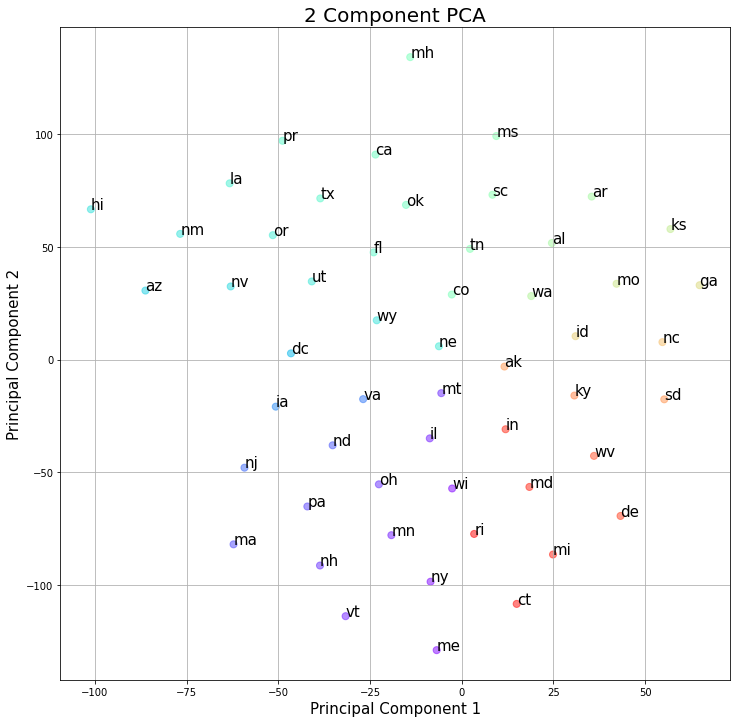

In [36]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

plt.scatter(finalDf.iloc[:,0], finalDf.iloc[:,1], c=np.arctan2(finalDf.iloc[:,0], finalDf.iloc[:,1]),cmap='rainbow', s=50, alpha=0.5)

ax.grid()

for i, txt in enumerate(finalDf.iloc[:,2]):
    ax.annotate(txt, (finalDf.iloc[i,0], finalDf.iloc[i,1]),fontsize=15)


In [74]:
word_to_index = t.word_index
index_to_word = dict()

for key in word_to_index:
    index_to_word.update({word_to_index[key] : key })

In [76]:
#similarity_matrix = Cosine_Similarity('60126',embeddings,word_to_index,vocab_size,index_to_word)

In [77]:
#similarity_matrix

In [60]:
word_to_index['il']

15

In [61]:
index_to_word[15]

'il'